<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY-9163-ML-cyber/blob/main/Lab/MLSec_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Adversarial Attacks on Deep Neural Networks

## Overview
In this lab, you will investigate adversarial perturbation attacks on Deep Neural Networks using the MNIST digits dataset as a benchmark. You will then evaluate adversarial retraining as a defense against adversarial perturbations.

## Dataset
The fashion_MNIST dataset is a commonly used “toy” benchmarks for machine learning. It contains 28X28 grayscale images with a label from 10 classes, along with the associated labels. The dataset is available as part of the tensorflow package, which you will be using extensively in this lab.

## What You Have to Do
The sample Google Colab notebook
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb#scrollTo=h3IKyzTCDNGo
that implements a 2-layer DNN for MNIST digit classification. The DNN has a 784 (28x28) dimensional input, a 10-dimensional output (prediction probabilities for each of the 10 classes) and one hidden layer with 300 hidden neurons and ReLU activations. You will implement your attacks and defenses on this baseline DNN.

* **FGSM based untargeted attacks**: Your first goal is to implement FGSM based untargeted attacks using images from the test set on the baseline DNN. That is, your goal is to adversarially perturb each image in the test set using the following values of parameter $\epsilon$ = {1, 5, 10, 20, 30, 40, 50}/255 assuming pixel values are normalized in the range [0,1]. Report the success rate of your attack, i.e., the fraction of test images that were
correctly classified by the baseline DNN that are mis-classified after adversarial perturbation, as a function of $\epsilon$.

* **FGSM based targeted attacks**: Next, you will repeat Step 1 above, except this time perform targeted attacks where digit i is classified as (i+1)%10 on the baseline DNN. (Here, i refers to the true ground-truth label of the test images, and you can assume that the attacker has access to these labels.) As before, use the following values of the parameter $\epsilon$ = {1, 5, 10, 20, 30, 40, 50}/255. Report the attack’s success rate as a function of parameter $\epsilon$, where success rate is defined as the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbations with label (i+1)%10.

* **Adversarial Retraining against Untargeted FGSM Attacks**: For this step, you can assume $\epsilon$ = 10/255 throughout. To defend against adversarial perturbations, the defender adversarially perturbs each image in her training set using the attacker’s strategy in Step 1. She then appends the adversarially perturbed images to her training set, but using their correct labels. Then, the defender retrains the baseline DNN with a new training dataset containing both images from the original training dataset and the new adversarially perturbed images. We call the new DNN the adversarially retrained DNN.

  *  Report the classification accuracy of the adversarially retrained DNN on the original test dataset that contains only clean inputs.
  * Is the adversarially retrained DNN robust against adversarial perturbations?
Implement FGSM based untargeted attacks using images from the clean test set on the adversarially retrained DNN. Report the success rate of your attack.

* **Challenge**: Finally, you will all compete in an adversarial attack challenge. You are free to use any adversarial attack detection procedure to implement untargeted attacks on a 2-layer baseline DNN. You are welcome to implement IFGSM or PGD attacks for example. For this problem you will simply submit your adversarially perturbed test images from the Fashion_MNIST dataset. The constraint is that the Root Mean Square Error averaged over all the images in the the original and modified datasets should be less than 5/255. assuming images are normalized to lie between [0,1].

## What to Submit
* Colab Notebook and its pdf format.
* Please submit 1 Colab Notebook and 1 PDF file without zipping.
* For the Challenge, please submit a file containing your adversarially modified test images



https://nextjournal.com/gkoehler/pytorch-mnist

https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

https://towardsdatascience.com/know-your-enemy-the-fascinating-implications-of-adversarial-examples-5936bccb24af

https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

https://www.pyimagesearch.com/2020/10/19/adversarial-images-and-attacks-with-keras-and-tensorflow/

https://www.pyimagesearch.com/2020/10/26/targeted-adversarial-attacks-with-keras-and-tensorflow/

https://www.pyimagesearch.com/2020/10/19/adversarial-images-and-attacks-with-keras-and-tensorflow/

https://www.pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/

## Import packages and Get Data

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Make sure we can use GPU

In [2]:
torch.cuda.is_available()

True

In [4]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [5]:
print("The train data size is: ", train_data.data.size())
print("The test data size is: ", test_data.data.size())

The train data size is:  torch.Size([60000, 28, 28])
The test data size is:  torch.Size([10000, 28, 28])


We will visualize the data

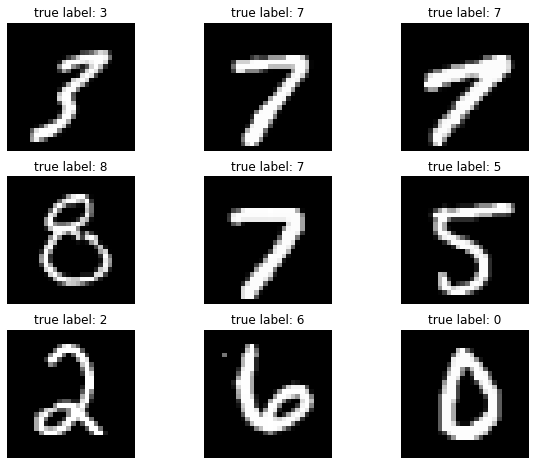

In [6]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = torch.randint(len(train_data),size=(1,)).item()
  img, label = train_data[index]
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

We need to prepare the dataloader for training

In [7]:
loaders = {
    'train':DataLoader(train_data,
                       batch_size = 64,
                       shuffle = True,
                       ),
    'test':DataLoader(test_data,
                      batch_size = 64,
                      shuffle = True),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f9d04ee6790>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f9d04ee6450>}

## Baseline DNN model
The DNN has a 784 (28x28) dimensional input, a 10-dimensional output (prediction probabilities for each of the 10 classes) and one hidden layer with 300 hidden neurons and ReLU activations.

In [46]:
class DNN(nn.Module):
  def __init__(self):
    super(DNN, self).__init__()
    # DNN has 28*28 dimensional input and one hidden layer with 300 neurons
    self.firstLayer = nn.Linear(28*28, 300)
    # 10 dimensional output
    self.secondLayer = nn.Linear(300, 10)
  
  def forward(self, x):
    # flatten the input to 784
    x = torch.flatten(x, 1) 
    x = F.relu(self.firstLayer(x))
    x = self.secondLayer(x)
    x = F.log_softmax(x)
    return x
DNN = DNN()
## we will print out the structure to see if it is correct
print(DNN)

DNN(
  (firstLayer): Linear(in_features=784, out_features=300, bias=True)
  (secondLayer): Linear(in_features=300, out_features=10, bias=True)
)


In [27]:
loss_func = nn.NLLLoss()

We will start to train the DNN model

In [18]:
optimizer = optim.Adam(DNN.parameters(), lr = 0.01) 
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [49]:

#DNN = DNN()
num_epochs = 1
def train_DNN(num_epochs, model, loaders):
  #model.train()
  total_step = len(loaders['train'])
  for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(loaders['train']):
      # imgs = imgs.view(imgs.shape[0],-1)
      x = Variable(imgs) # batch size is 64
      y = Variable(labels) # batch size is 64
      pred = model(x)
      loss = loss_func(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if (i%64)==0:
        print('epoch:[{}/{}], step[{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))



train_DNN(num_epochs, DNN, loaders)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:[1/1], step[1/938], loss:2.2944
epoch:[1/1], step[65/938], loss:2.3006
epoch:[1/1], step[129/938], loss:2.2860
epoch:[1/1], step[193/938], loss:2.2757
epoch:[1/1], step[257/938], loss:2.2940
epoch:[1/1], step[321/938], loss:2.2915
epoch:[1/1], step[385/938], loss:2.2867
epoch:[1/1], step[449/938], loss:2.2908
epoch:[1/1], step[513/938], loss:2.2840
epoch:[1/1], step[577/938], loss:2.2915
epoch:[1/1], step[641/938], loss:2.2832
epoch:[1/1], step[705/938], loss:2.3110
epoch:[1/1], step[769/938], loss:2.2972
epoch:[1/1], step[833/938], loss:2.2865
epoch:[1/1], step[897/938], loss:2.2948


In [35]:
correct_count, all_count = 0, 0
for img, label in loaders['test']:
  for i in range(len(label)):
    prob = DNN(img)
    ps = torch.exp(prob)
    probab = list(ps.detach().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = label.numpy()[i]
    if(true_label==pred_label):
      correct_count+=1
    all_count+=1
print(correct_count/all_count)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


0.1018


## FGSM based untargeted attacks

## FGSM based targeted attacks

## Adversarial Retraining against Untargeted FGSM Attacks

## Challenge